In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from scipy import stats
from datetime import datetime
from utils.traveling import calculate_distance
from statsmodels.stats.diagnostic import lilliefors
from fitter import Fitter

### Read Data

In [2]:
drivers_df = pd.read_excel('../data/drivers.xlsx')
riders_df = pd.read_excel('../data/riders.xlsx')

In [3]:
def convert_time_to_float(time_series):
    # Convert to datetime objects
    deltas = time_series.diff().dt.total_seconds().dropna().tolist()
    deltas = np.array(deltas)/60
    return deltas

In [4]:
def mle_params(series, dist_name):
    if dist_name == 'exponential':
        dist = stats.expon
    elif dist_name == 'uniform':
        dist = stats.uniform
    else:
        raise ValueError(f"Unsupported distribution: {dist_name}")
    return dist.fit(series, floc=0)

In [5]:
def ks_test(series, dist_name, params):
    """
    Performs the Kolmogorov-Smirnov (KS) test while correctly passing estimated parameters
    to the cumulative distribution function (CDF), including degrees of freedom adjustments.

    :param series: Numeric data series (e.g., time deltas).
    :param dist_name: Name of the distribution ('exponential', 'uniform', etc.).
    :return: KS statistic and p-value.
    """
    if dist_name == 'exponential':
        dist = stats.expon
    elif dist_name == 'uniform':
        dist = stats.uniform
    else:
        raise ValueError(f"Unsupported distribution: {dist_name}")

    n = len(series)
    # Perform KS test and explicitly pass fitted parameters (including df adjustment)
    ks_stat, p_value = stats.kstest(series, dist.cdf, args=params, N=n)

    return ks_stat, p_value



In [6]:
def lilliefors_test(data, dist_type='Gaussian', conf_level=0.95):
    """
    Performs Lilliefors Test for Normal (Gaussian) or Exponential distribution.
    Computes confidence interval using the correct statistical method and plots distribution over histogram.
    
    :param data: Numeric dataset (1D array-like).
    :param dist_type: 'Gaussian' or 'Exponential'.
    :param conf_level: Confidence level for interval estimation (default: 0.95).
    :return: Test statistic, p-value, confidence interval, estimated parameters.
    """
    n = len(data)
    alpha = 1 - conf_level  # Alpha level for two-tailed test

    if dist_type.lower() == 'gaussian':
        # Lilliefors Test for Normality
        stat, p_value = lilliefors(data, dist='norm')

        # Mean Confidence Interval using t-distribution
        mean_est = np.mean(data)
        std_err = np.std(data, ddof=1)
        t_crit = stats.t.ppf(1 - alpha / 2, df=n - 1)  # Two-tailed t critical value
        ci = (mean_est - t_crit * std_err, mean_est + t_crit * std_err)
        params = (mean_est, std_err)
    
    elif dist_type.lower() == 'exponential':
        # Lilliefors Test for Exponential Distribution
        stat, p_value = lilliefors(data, dist='exp')

        # Estimate rate parameter (lambda)
        lambda_est = 1 / np.mean(data)  

        # Confidence Interval using Gamma distribution approximation
        std_err = np.std(data, ddof=1) / np.sqrt(n)  # Standard error of the mean
        t_crit = stats.t.ppf(1 - alpha / 2, df=n - 1)  # t critical value
        lambda_lower = 1 / (np.mean(data) + t_crit * std_err)
        lambda_upper = 1 / (np.mean(data) - t_crit * std_err)
        ci = (lambda_lower, lambda_upper)
        params = (lambda_est,)
    
    else:
        raise ValueError("dist_type must be 'Gaussian' or 'Exponential'")
    
    # Plot histogram and estimated distribution
    plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label='Observed Data')
    
    x = np.linspace(min(data), max(data), 1000)
    if dist_type.lower() == 'gaussian':
        pdf = stats.norm.pdf(x, loc=params[0], scale=params[1])
        plt.plot(x, pdf, 'g-', lw=2, label='Estimated Gaussian')
    elif dist_type.lower() == 'exponential':
        pdf = stats.expon.pdf(x, scale=1/params[0])
        plt.plot(x, pdf, 'g-', lw=2, label='Estimated Exponential')
    
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Histogram vs Estimated {dist_type} Distribution")
    plt.show()
    
    return stat, p_value, ci, params

In [7]:
def estimate_beta_parameters(data):
    """
    Estimate the parameters (alpha, beta, loc, scale) of a Beta distribution using MLE.
    :param data: Dataset.
    :return: Estimated alpha, beta, loc, and scale parameters.
    """
    alpha_est, beta_est, loc, scale = stats.beta.fit(data, floc=0, fscale=20)  # Allow estimation of loc and scale
    return alpha_est, beta_est, loc, scale

def estimate_uniform_parameters(data):
    """
    Estimate the parameters (min, max) of a Uniform distribution using MLE.
    :param data: Dataset.
    :return: Estimated min and max parameters.
    """
    min_est, scale_est = stats.uniform.fit(data)[:2]  # Extract loc (min) and scale (max - min)
    max_est = min_est + scale_est
    return min_est, max_est

def ks_test_mc(data, dist_type='beta', n_bootstrap=1000):
    """
    Monte Carlo-adjusted Kolmogorov-Smirnov Goodness-of-Fit test for Beta or Uniform distribution.
    :param data: Dataset.
    :param dist_type: Distribution type ('beta' or 'uniform').
    :param n_bootstrap: Number of bootstrap resamples for adjustment.
    :return: Adjusted KS test statistic, empirical p-value, estimated parameters.
    """
    if not isinstance(n_bootstrap, int):
        raise ValueError("n_bootstrap must be an integer.")

    # Estimate distribution parameters
    if dist_type == 'beta':
        param1, param2, loc, scale = estimate_beta_parameters(data)
        cdf_func = stats.beta.cdf
        args = (param1, param2, loc, scale)  # Allow loc and scale
    elif dist_type == 'uniform':
        param1, param2 = estimate_uniform_parameters(data)
        cdf_func = stats.uniform.cdf
        args = (param1, param2 - param1)  # Convert to loc and scale
    else:
        raise ValueError("dist_type must be 'beta' or 'uniform'")

    # Compute original KS test statistic
    ks_stat, og_p = stats.kstest(data, cdf_func, args=args)

    # Monte Carlo Resampling
    simulated_stats = []
    for _ in range(n_bootstrap):
        if dist_type == 'beta':
            simulated_data = stats.beta.rvs(param1, param2, loc=loc, scale=scale, size=len(data))
            sim_param1, sim_param2, sim_loc, sim_scale = estimate_beta_parameters(simulated_data)
            sim_args = (sim_param1, sim_param2, sim_loc, sim_scale)
        elif dist_type == 'uniform':
            simulated_data = stats.uniform.rvs(param1, param2 + param1, size=len(data))
            sim_param1, sim_param2 = estimate_uniform_parameters(simulated_data)
            sim_args = (sim_param1, sim_param2 + sim_param1)
        sim_ks_stat, _ = stats.kstest(simulated_data, cdf_func, args=sim_args)
        simulated_stats.append(sim_ks_stat)

    # Compute empirical p-value
    adjusted_p_value = np.mean(np.array(simulated_stats) >= ks_stat)

    return ks_stat, adjusted_p_value, args, og_p

def plot_distribution_fit(data, args, dist_type='beta', num_bins=50):
    """
    Plots the histogram of data alongside the estimated Beta or Uniform distribution.
    :param data: Dataset.
    :param param1: Estimated parameter 1.
    :param param2: Estimated parameter 2.
    :param loc: Estimated location parameter.
    :param scale: Estimated scale parameter.
    :param dist_type: Distribution type ('beta' or 'uniform').
    :param num_bins: Number of bins for histogram.
    """
    data_min, data_max = np.min(data), np.max(data)


    # Plot histogram
    plt.hist(data, bins=num_bins, density=True, alpha=0.6, color='g', label='Observed Data')

    # Generate fitted PDF
    x = np.linspace(data_min, data_max, 1000)
    if dist_type == 'beta':
        param1 = args[0]
        param2 = args[1] 
        loc = args[2] 
        scale = args[3]
        pdf = stats.beta.pdf(x, param1, param2, loc=loc, scale=scale)  # Allow loc and scale
    elif dist_type == 'uniform':
        param1 = args[0]
        param2 = args[1] 
        pdf = stats.uniform.pdf(x, param1, param2)  # Ensure correct loc & scale
    plt.plot(x, pdf, 'r-', lw=2, label=f'Estimated {dist_type.capitalize()} Distribution')

    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Histogram vs Estimated {dist_type.capitalize()} Distribution")
    plt.show()

In [8]:
deltas_drivers = convert_time_to_float(drivers_df['arrival_datetime'])
deltas_riders = convert_time_to_float(riders_df['request_datetime'])

(array([42., 50., 35., 30., 31., 30., 25., 17., 19., 16., 13.,  7.,  5.,
        11.,  9.,  6.,  3.,  6.,  4.,  0.,  0.,  0.,  5.,  1.,  2.,  4.,
         2.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.01550000e-01, 2.14590067e+00, 4.19025133e+00, 6.23460200e+00,
        8.27895267e+00, 1.03233033e+01, 1.23676540e+01, 1.44120047e+01,
        1.64563553e+01, 1.85007060e+01, 2.05450567e+01, 2.25894073e+01,
        2.46337580e+01, 2.66781087e+01, 2.87224593e+01, 3.07668100e+01,
        3.28111607e+01, 3.48555113e+01, 3.68998620e+01, 3.89442127e+01,
        4.09885633e+01, 4.30329140e+01, 4.50772647e+01, 4.71216153e+01,
        4.91659660e+01, 5.12103167e+01, 5.32546673e+01, 5.52990180e+01,
        5.73433687e+01, 5.93877193e+01, 6.14320700e+01, 6.34764207e+01,
        6.55207713e+01, 6.75651220e+01, 6.96094727e+01, 7.16538233e+01,
        7.36981740e+01, 7.57425247e+01, 7.77868753e+01, 7.98312260e+

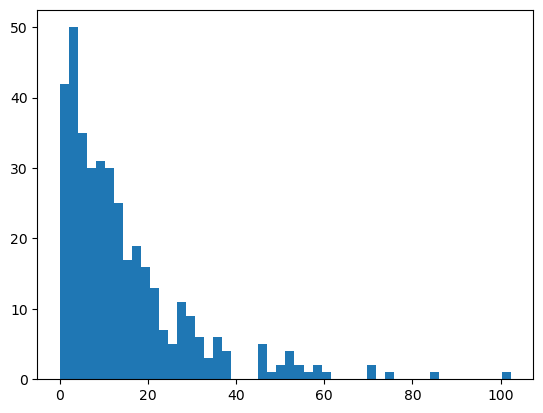

In [9]:
plt.hist(deltas_drivers, bins= 50)

(array([650., 467., 392., 328., 261., 186., 146., 126., 100.,  85.,  79.,
         46.,  36.,  20.,  20.,  24.,  21.,   9.,   5.,   8.,   4.,   4.,
          5.,   3.,   2.,   1.,   2.,   3.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.16666667e-04, 4.35554333e-01, 8.70492000e-01, 1.30542967e+00,
        1.74036733e+00, 2.17530500e+00, 2.61024267e+00, 3.04518033e+00,
        3.48011800e+00, 3.91505567e+00, 4.34999333e+00, 4.78493100e+00,
        5.21986867e+00, 5.65480633e+00, 6.08974400e+00, 6.52468167e+00,
        6.95961933e+00, 7.39455700e+00, 7.82949467e+00, 8.26443233e+00,
        8.69937000e+00, 9.13430767e+00, 9.56924533e+00, 1.00041830e+01,
        1.04391207e+01, 1.08740583e+01, 1.13089960e+01, 1.17439337e+01,
        1.21788713e+01, 1.26138090e+01, 1.30487467e+01, 1.34836843e+01,
        1.39186220e+01, 1.43535597e+01, 1.47884973e+01, 1.52234350e+01,
        1.

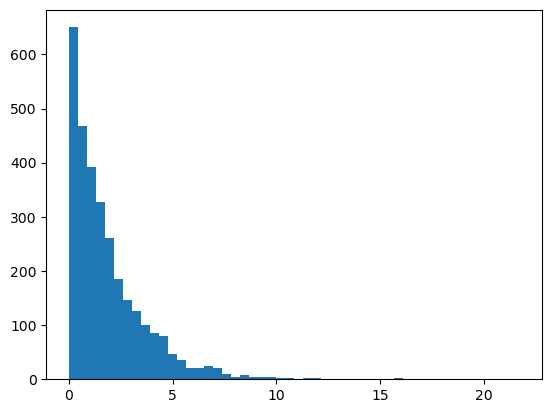

In [10]:
plt.hist(deltas_riders, bins= 50)

### Test Inter-Arrival

### Test using Given params

In [11]:
drivers_ks_test = ks_test(deltas_drivers, 'exponential', (0, 1/0.05))
drivers_ks_test

(0.13650147793000822, 1.1395508701405754e-06)

In [12]:
riders_ks_test = ks_test(deltas_riders, 'exponential', (0, 1/0.5))
riders_ks_test

(0.03015083109996064, 0.007804816052519704)

In [13]:
1 / mle_params(deltas_drivers, 'exponential')[1]

0.06818402519746007

In [14]:
1 / mle_params(deltas_riders, 'exponential')[1]

0.5335198676870729

### Estimating the params

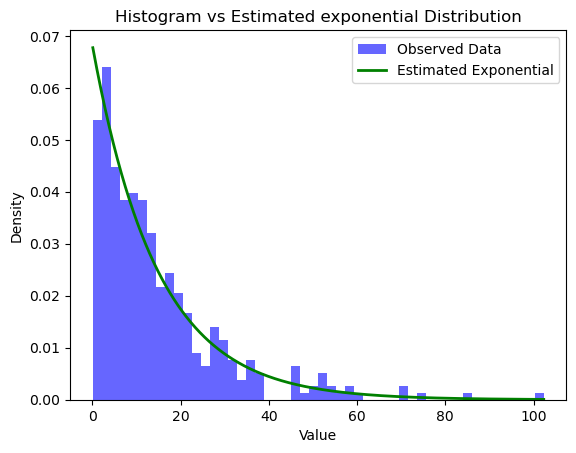

(0.033641475403197535,
 0.6077850403741438,
 (0.06193679188850667, 0.07583288297649236),
 (0.06818402519746007,))

In [15]:
lilliefors_test(deltas_drivers, 'exponential')

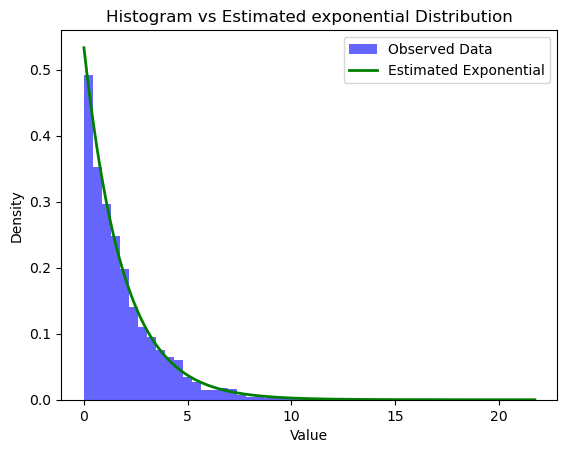

(0.010944047713855376,
 0.7085316348507027,
 (0.514828994305749, 0.5536190132128784),
 (0.5335198676870729,))

In [16]:
lilliefors_test(deltas_riders, 'exponential')

### Driver jobs time

In [17]:
sample_jobs_time = (drivers_df['offline_datetime'] - drivers_df['arrival_datetime']).dt.total_seconds()
sample_jobs_time = np.array(sample_jobs_time) / 60
ks_test(sample_jobs_time, 'uniform', (300, 180))

(0.3363903703703705, 3.71905609852589e-39)

Monte Carlo Adjusted KS Test for Uniform Distribution: 0.054990503008847114 1.0 (360.5502666666667, 117.98924999999997)
unadjust: 0.18995944908057372


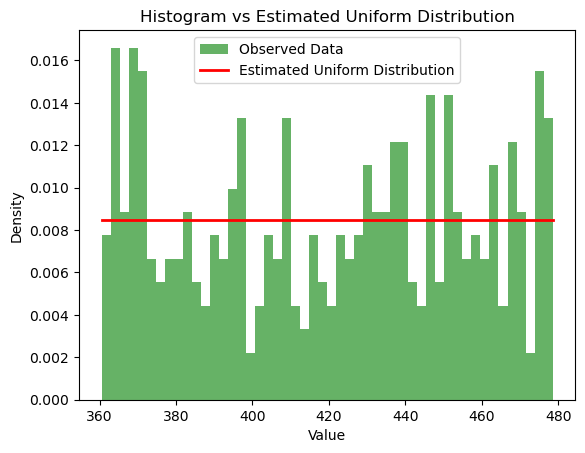

In [18]:
test_stat_uniform, p_value_uniform, uniform_params, og_p = ks_test_mc(sample_jobs_time, dist_type='uniform')
print("Monte Carlo Adjusted KS Test for Uniform Distribution:", test_stat_uniform, p_value_uniform, uniform_params)
print("unadjust:", og_p)
plot_distribution_fit(sample_jobs_time, uniform_params, dist_type='uniform')

In [19]:
sample_jobs_time.max()

478.53951666666666

In [20]:
sample_jobs_time.min()

360.5502666666667

(array([59., 31., 31., 31., 31., 34., 43., 43., 33., 47.]),
 array([360.55026667, 372.34919167, 384.14811667, 395.94704167,
        407.74596667, 419.54489167, 431.34381667, 443.14274167,
        454.94166667, 466.74059167, 478.53951667]),
 <BarContainer object of 10 artists>)

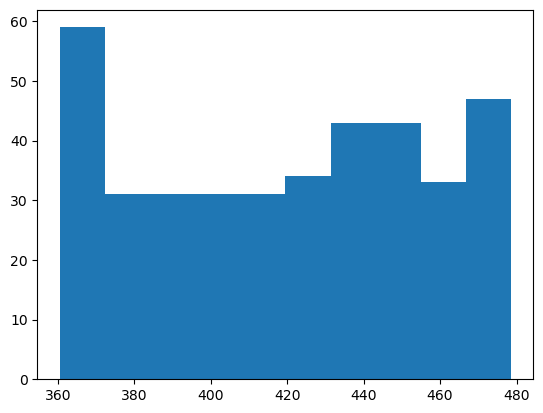

In [21]:
plt.hist(sample_jobs_time, bins="auto")

#### Riders patience time

No values might be testable using status count (binomial test)

### Origins and Destination

#### Drivers, riders Origin, riders destination

In [22]:
drivers_df['initial_location'] = drivers_df['initial_location'].apply(lambda x: eval(x))
riders_df['pickup_location'] = riders_df['pickup_location'].apply(lambda x: eval(x))
riders_df['dropoff_location'] = riders_df['dropoff_location'].apply(lambda x: eval(x))

In [23]:
driver_origin_x = drivers_df['initial_location'].apply(lambda x: x[0])
driver_origin_y = drivers_df['initial_location'].apply(lambda x: x[1])
rider_origin_x = riders_df['pickup_location'].apply(lambda x: x[0])
rider_origin_y = riders_df['pickup_location'].apply(lambda x: x[1])
rider_dest_x = riders_df['dropoff_location'].apply(lambda x: x[0])
rider_dest_y = riders_df['dropoff_location'].apply(lambda x: x[1])

<Axes: >

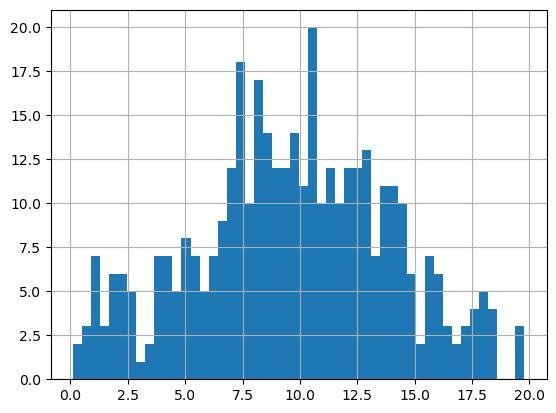

In [24]:
driver_origin_x.hist(bins=50)

<Axes: >

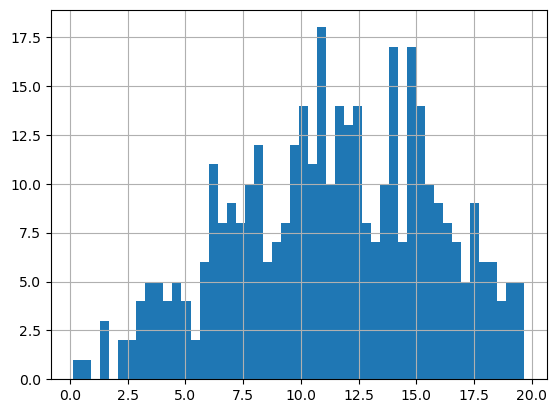

In [25]:
driver_origin_y.hist(bins=50)

<Axes: >

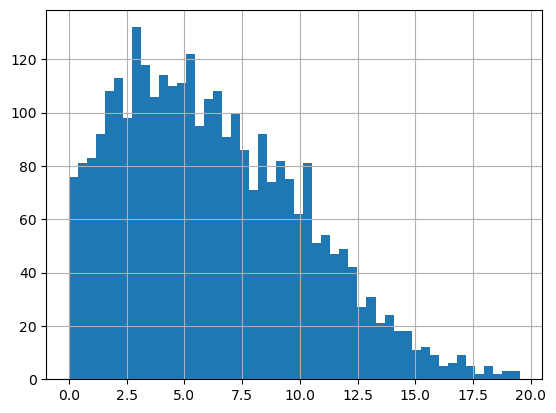

In [26]:
rider_origin_x.hist(bins=50)

<Axes: >

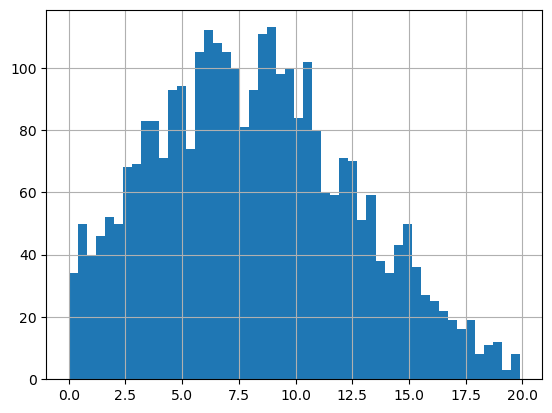

In [27]:
rider_origin_y.hist(bins=50)

<Axes: >

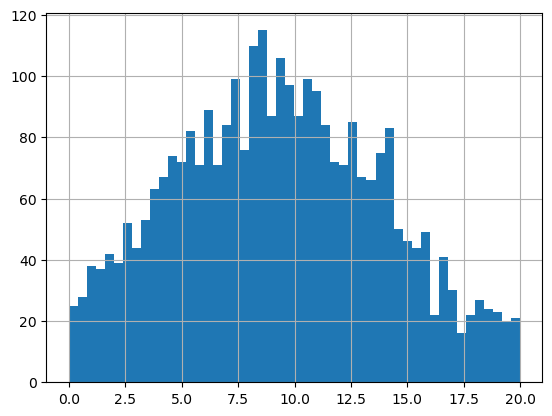

In [28]:
rider_dest_x.hist(bins=50)

<Axes: >

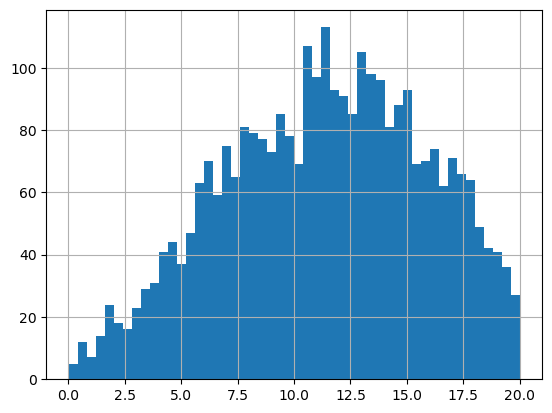

In [29]:
rider_dest_y.hist(bins=50)

#### suspiciously Gaussian

In [30]:
ks_test(driver_origin_x, 'uniform', (0, 20))

(0.15445515704023938, 1.913111142242514e-08)

In [31]:
ks_test(driver_origin_y, 'uniform', (0, 20))

(0.18940735696757516, 1.6636954793638068e-12)

In [32]:
ks_test(rider_origin_x, 'uniform', (0, 20))

(0.32450008498277694, 1.8960142616459827e-285)

In [33]:
ks_test(rider_origin_y, 'uniform', (0, 20))

(0.20654645766806135, 3.220341345129774e-114)

In [34]:
ks_test(rider_dest_x, 'uniform', (0, 20))

(0.13780035899024268, 8.134954839839249e-51)

In [35]:
ks_test(rider_dest_y, 'uniform', (0, 20))

(0.16744178714027674, 5.728045182799932e-75)

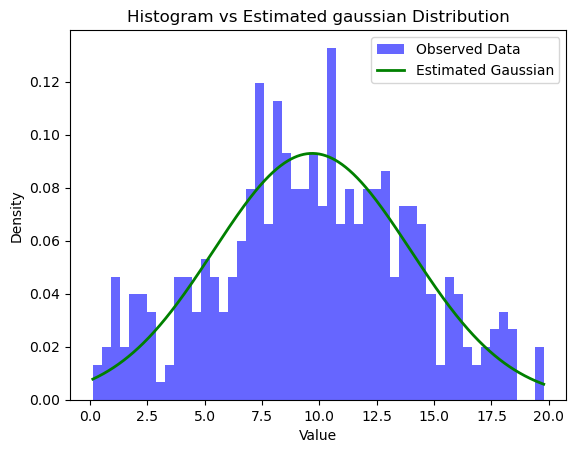

(0.028468495409453898,
 0.6680882513315634,
 (1.2460525787607963, 18.123172616364798),
 (9.684612597562797, 4.291825799191204))

In [36]:
lilliefors_test(driver_origin_x, 'gaussian')

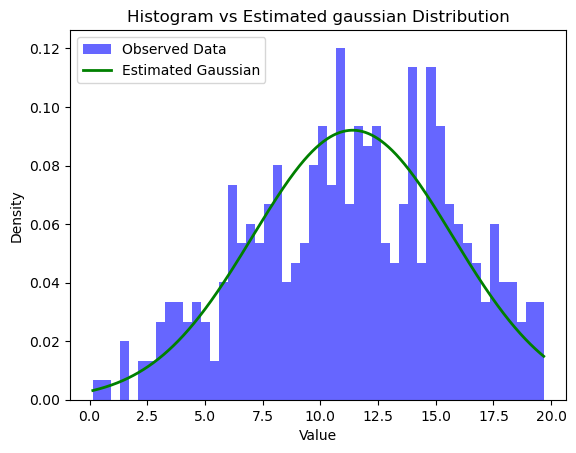

(0.05219585799347648,
 0.017283773359497316,
 (2.8787814248840657, 19.9169480768346),
 (11.397864750859334, 4.332779706776433))

In [37]:
lilliefors_test(driver_origin_y, 'gaussian')

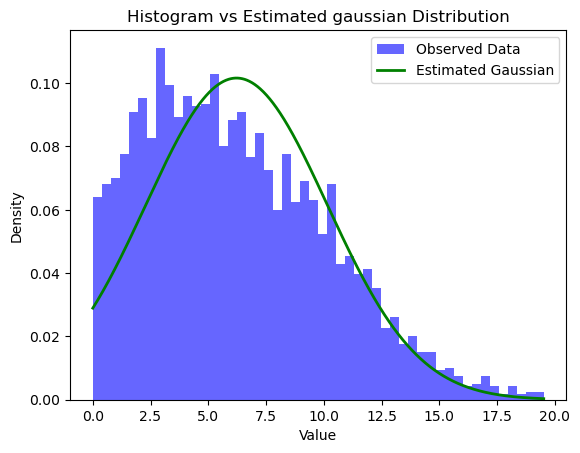

(0.061133444326268604,
 0.0009999999999998899,
 (-1.4746380709403342, 13.920665039086956),
 (6.22301348407331, 3.925881208392018))

In [38]:
lilliefors_test(rider_origin_x, 'gaussian')

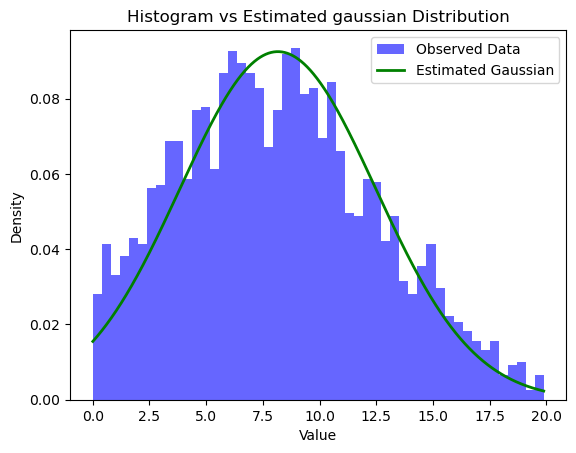

(0.0340276903840907,
 0.0009999999999998899,
 (-0.2978380567484056, 16.620900546702522),
 (8.161531244977057, 4.31436506824755))

In [39]:
lilliefors_test(rider_origin_y, 'gaussian')

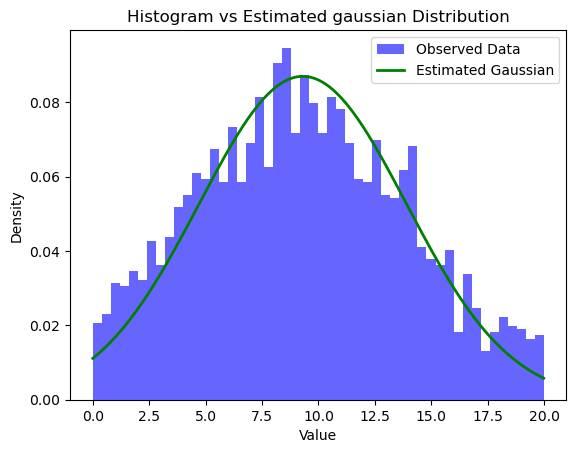

(0.02745854291649802,
 0.0009999999999998899,
 (0.311715624100918, 18.301694886288054),
 (9.306705255194485, 4.587536927336105))

In [40]:
lilliefors_test(rider_dest_x, 'gaussian')

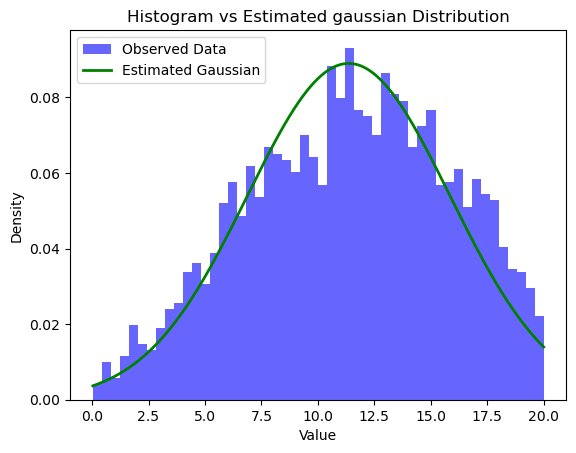

(0.033214405122821256,
 0.0009999999999998899,
 (2.5668889584478745, 20.154458885216442),
 (11.36067392183216, 4.48492048407996))

In [41]:
lilliefors_test(rider_dest_y, 'gaussian')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.0655439167796891
Adjusted p-value: 0.003
unadjust: 0.0711751073952045
Estimated Beta Parameters (alpha, beta): (1.9264996845279385, 2.076625399405819, 0, 20)


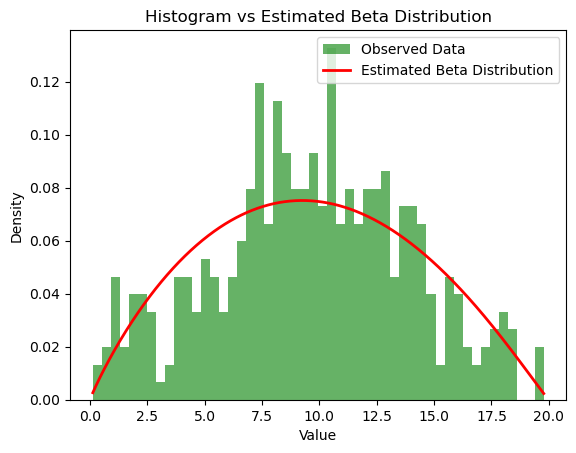

In [42]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(driver_origin_x, 'beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(driver_origin_x, beta_params, 'beta')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.029834330419966748
Adjusted p-value: 0.604
unadjust: 0.8745576424075068
Estimated Beta Parameters (alpha, beta): (2.315640481296582, 1.7542831588831131, 0, 20)


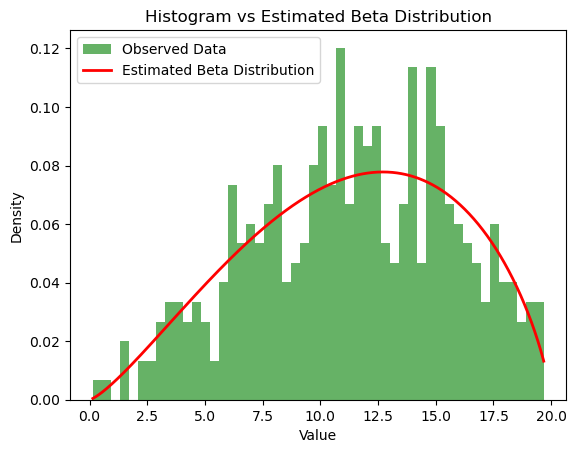

In [43]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(driver_origin_y, dist_type='beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(driver_origin_y, beta_params, 'beta')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.017811798523422517
Adjusted p-value: 0.035
unadjust: 0.2863257283912062
Estimated Beta Parameters (alpha, beta): (1.3376945303755767, 2.9727920169736164, 0, 20)


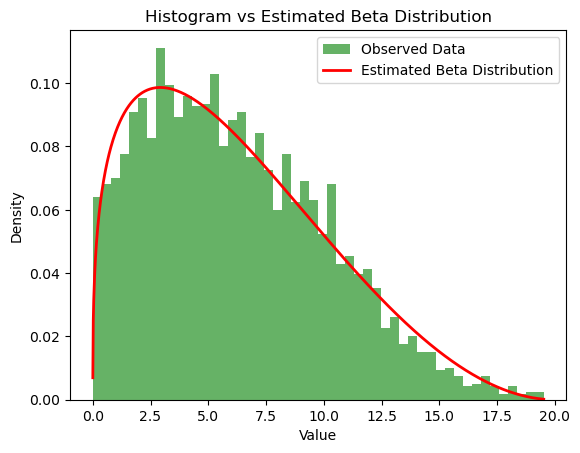

In [44]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(rider_origin_x, 'beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(rider_origin_x, beta_params, 'beta')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.030422217494379955
Adjusted p-value: 0.0
unadjust: 0.007048117984191212
Estimated Beta Parameters (alpha, beta): (1.5771271610684952, 2.296333422469874, 0, 20)


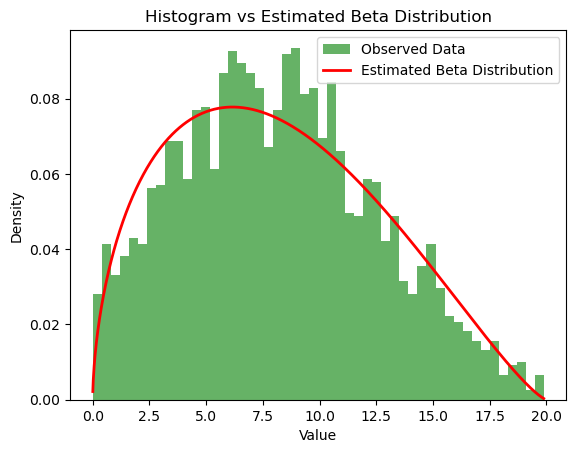

In [45]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(rider_origin_y, 'beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(rider_origin_y, beta_params, 'beta')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.03373331994421769
Adjusted p-value: 0.0
unadjust: 0.001931903009504422
Estimated Beta Parameters (alpha, beta): (1.5703459178793435, 1.792987015560893, 0, 20)


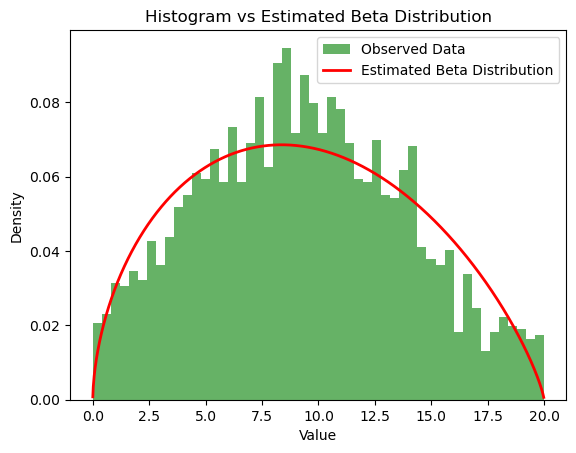

In [46]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(rider_dest_x, 'beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(rider_dest_x, beta_params, 'beta')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.021866499641592152
Adjusted p-value: 0.001
unadjust: 0.1076577143095907
Estimated Beta Parameters (alpha, beta): (2.0868903945969657, 1.5836969275237693, 0, 20)


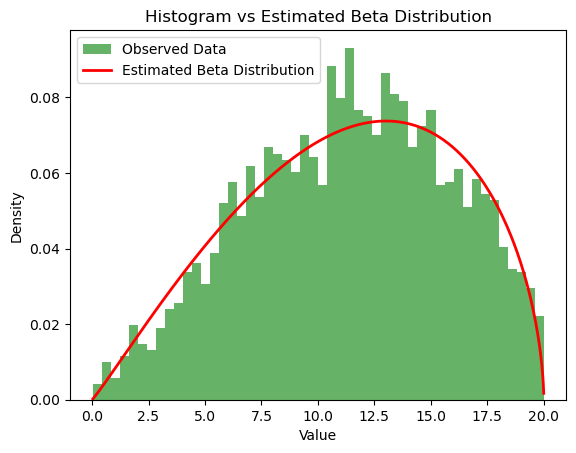

In [47]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(rider_dest_y, 'beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(rider_dest_y, beta_params, 'beta')

### Test Origins and Destination

In [48]:
sample_travel_time_series = (riders_df['dropoff_datetime'] - riders_df['pickup_datetime']).dt.total_seconds()
sample_travel_time = sample_travel_time_series[~ sample_travel_time_series.isna()]
sample_travel_time = np.array(sample_travel_time) / 60
sample_travel_time

array([20.83455   , 19.5621    , 24.35865   , ..., 58.10045   ,
       31.03663333, 27.64033333])

In [49]:
sample_dist = calculate_distance(rider_origin_x, rider_origin_y, rider_dest_x, rider_dest_y)[~ sample_travel_time_series.isna()]

In [50]:
sample_speed = sample_dist / sample_travel_time
sample_speed

0       0.344767
1       0.308847
3       0.374602
4       0.371420
5       0.393921
          ...   
3027    0.349933
3029    0.328338
3030    0.303897
3032    0.279918
3036    0.293838
Length: 2881, dtype: float64

(array([ 3.,  4.,  9., 10., 12., 13., 12., 15., 24., 27., 23., 32., 31.,
        50., 47., 46., 45., 39., 42., 53., 52., 54., 54., 60., 41., 49.,
        66., 44., 56., 52., 53., 48., 66., 55., 51., 44., 56., 50., 53.,
        63., 63., 56., 43., 54., 50., 51., 49., 57., 34., 42., 47., 41.,
        42., 42., 40., 34., 42., 35., 31., 37., 29., 26., 20., 23., 26.,
        21., 24., 20., 23., 15., 13., 16., 16., 14., 10.,  9., 10.,  7.,
        14.,  7.,  7.,  6.,  4.,  8.,  2.,  2.,  1.,  1.,  0.,  5.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([ 0.0991039 ,  0.326719  ,  0.55433411,  0.78194921,  1.00956431,
         1.23717941,  1.46479451,  1.69240961,  1.92002471,  2.14763981,
         2.37525491,  2.60287002,  2.83048512,  3.05810022,  3.28571532,
         3.51333042,  3.74094552,  3.96856062,  4.19617572,  4.42379082,
         4.65140593,  4.87902103,  5.10663613,  5.33425123,  5.56186633,
         5.78948143,  6.01709653,  6.24471163,  6.47232673,  6.699941

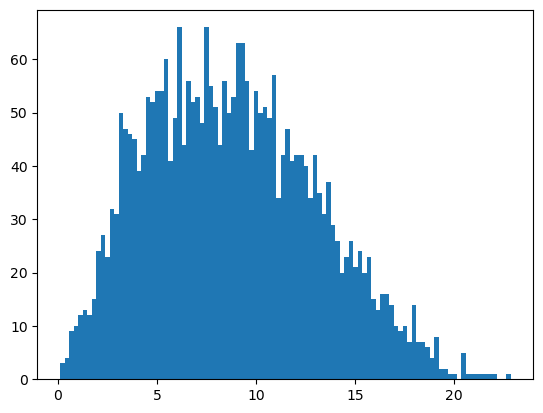

In [51]:
plt.hist(sample_dist, bins=100)

(array([ 3.,  5., 13.,  9., 18., 12., 14., 24., 19., 32., 40., 42., 51.,
        43., 51., 41., 54., 49., 65., 54., 65., 55., 62., 54., 41., 65.,
        55., 71., 55., 62., 59., 47., 59., 48., 64., 72., 48., 46., 58.,
        55., 50., 53., 62., 47., 50., 46., 54., 52., 36., 38., 38., 31.,
        41., 35., 24., 27., 35., 37., 18., 30., 22., 24., 25., 19., 21.,
        12., 11., 11., 17., 11., 16., 10.,  9., 14.,  8.,  7.,  9.,  7.,
         8.,  3.,  4.,  3.,  2.,  5.,  3.,  2.,  1.,  2.,  2.,  3.,  0.,
         0.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,  1.]),
 array([ 0.31245 ,  1.044251,  1.776052,  2.507853,  3.239654,  3.971455,
         4.703256,  5.435057,  6.166858,  6.898659,  7.63046 ,  8.362261,
         9.094062,  9.825863, 10.557664, 11.289465, 12.021266, 12.753067,
        13.484868, 14.216669, 14.94847 , 15.680271, 16.412072, 17.143873,
        17.875674, 18.607475, 19.339276, 20.071077, 20.802878, 21.534679,
        22.26648 , 22.998281, 23.730082, 24.461883, 25.193684, 2

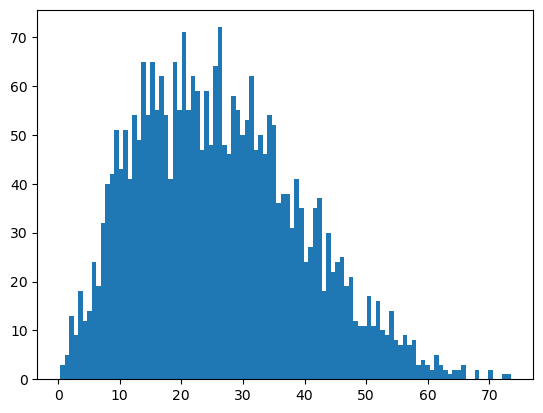

In [52]:
plt.hist(sample_travel_time, bins=100)

<Axes: >

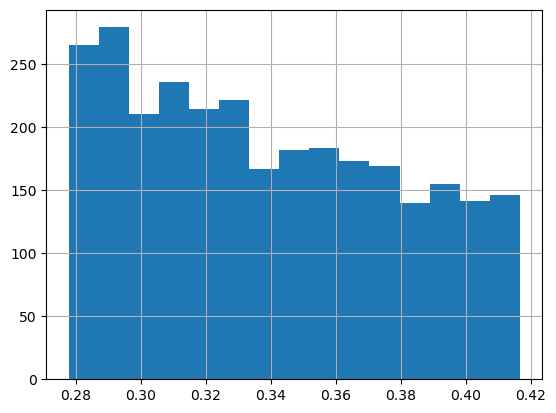

In [53]:
sample_speed.hist(bins="auto")

<Axes: >

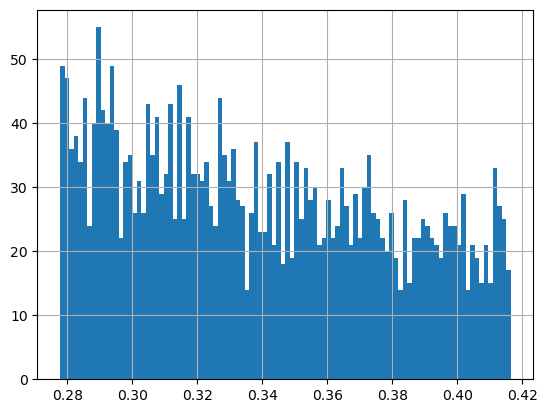

In [54]:
sample_speed.hist(bins=100)

In [55]:
ks_test(sample_speed, 'uniform', (((2/6) * 0.8), ((2/6) * 1.2)))

(0.6253361170526348, 0.0)

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.09639678881574126
Adjusted p-value: 1.0
unadjust: 9.405607929366507e-24
Estimated Beta Parameters (alpha, beta): (0.27777931360185476, 0.13875290624375797)


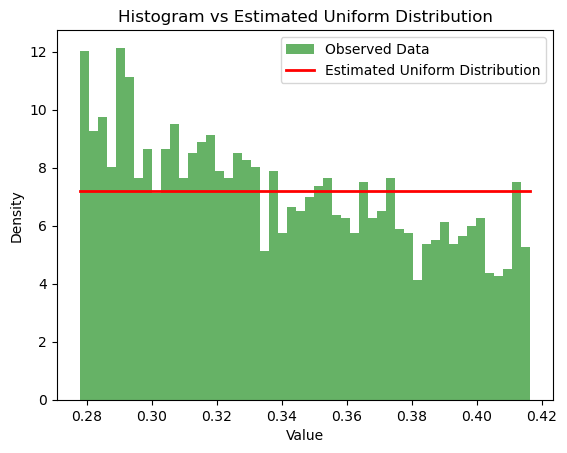

In [56]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(sample_speed, 'uniform')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(sample_speed, beta_params, 'uniform')

Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic: 0.06535893088156425
Adjusted p-value: 0.0
unadjust: 3.82815788830391e-11
Estimated Beta Parameters (alpha, beta): (71.29504119390546, 4135.511981016088, 0, 20)


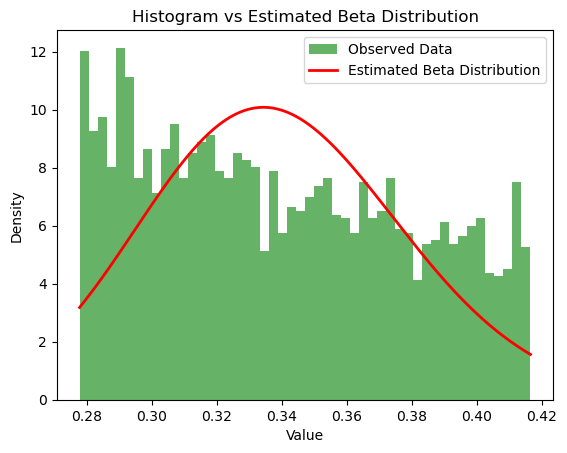

In [57]:
ks_stat, ks_p_value, beta_params, og_p = ks_test_mc(sample_speed, 'beta')
print("Monte Carlo Adjusted Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Adjusted p-value:", ks_p_value)
print("unadjust:", og_p)
print("Estimated Beta Parameters (alpha, beta):", beta_params)
plot_distribution_fit(sample_speed, beta_params, 'beta')

/home/punny/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3863: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  intgrl = integrate.quad(llc, x0, x1,
/home/punny/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3863: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  intgrl = integrate.quad(llc, x0, x1,
/home/punny/anacon

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,249.069445,-378.517415,-7005.356427,0.024490,0.010101,0.927510
bradford,250.071332,-384.600907,-7017.688472,0.024565,0.010046,0.930352
truncexpon,256.681061,-383.366425,-6942.528657,0.025315,0.018875,0.253047
beta,280.377031,-382.904460,-6680.167783,0.027883,0.026626,0.033047
powerlaw,284.139485,-385.539623,-6649.729876,0.027301,0.029186,0.014478


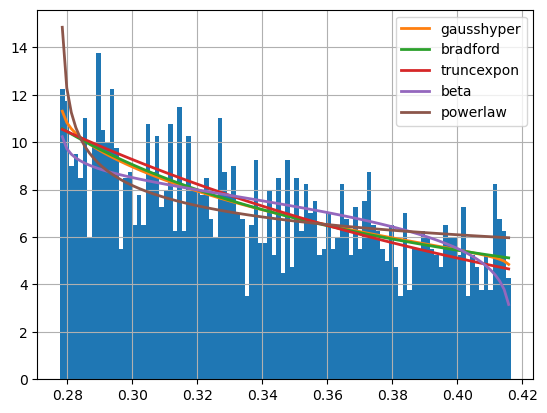

In [58]:
f = Fitter(sample_speed)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

### CI 

In [59]:
def ks_confidence_interval(ks_stat, n, alpha=0.05):
    """
    Computes the confidence interval for the KS statistic.

    :param ks_stat: The KS test statistic.
    :param n: Sample size used in the KS test.
    :param alpha: Significance level (default: 0.05 for 95% CI).
    :return: (lower_bound, upper_bound) confidence interval for the KS statistic.
    """
    z_critical = stats.norm.ppf(1 - alpha / 2)  # 1.96 for 95% CI
    se = 1 / np.sqrt(n)  # Standard error approximation

    lower_bound = max(0, ks_stat - z_critical * se)  # Ensure CI is non-negative
    upper_bound = min(1, ks_stat + z_critical * se)  # KS statistic cannot exceed 1

    return lower_bound, upper_bound

In [60]:
drivers_ks_ci = ks_confidence_interval(drivers_ks_test[0], len(deltas_drivers))
drivers_ks_ci

(0.03622099666230065, 0.23678195919771577)

(array([650., 467., 392., 328., 261., 186., 146., 126., 100.,  85.,  79.,
         46.,  36.,  20.,  20.,  24.,  21.,   9.,   5.,   8.,   4.,   4.,
          5.,   3.,   2.,   1.,   2.,   3.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.16666667e-04, 4.35554333e-01, 8.70492000e-01, 1.30542967e+00,
        1.74036733e+00, 2.17530500e+00, 2.61024267e+00, 3.04518033e+00,
        3.48011800e+00, 3.91505567e+00, 4.34999333e+00, 4.78493100e+00,
        5.21986867e+00, 5.65480633e+00, 6.08974400e+00, 6.52468167e+00,
        6.95961933e+00, 7.39455700e+00, 7.82949467e+00, 8.26443233e+00,
        8.69937000e+00, 9.13430767e+00, 9.56924533e+00, 1.00041830e+01,
        1.04391207e+01, 1.08740583e+01, 1.13089960e+01, 1.17439337e+01,
        1.21788713e+01, 1.26138090e+01, 1.30487467e+01, 1.34836843e+01,
        1.39186220e+01, 1.43535597e+01, 1.47884973e+01, 1.52234350e+01,
        1.

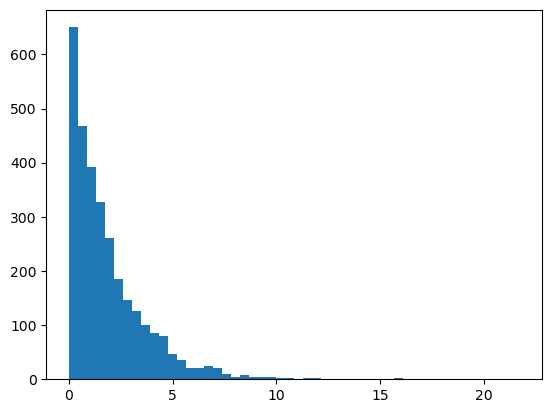

In [61]:
plt.hist(deltas_riders, bins= 50)

In [62]:
ks_test(deltas_drivers, 'exponential')

TypeError: ks_test() missing 1 required positional argument: 'params'

In [ ]:
ks_test(deltas_riders, 'exponential')

In [ ]:
1 / estimates_params(deltas_drivers, 'exponential')[1]

In [ ]:
deltas_riders = convert_time_to_float(riders_df['request_datetime'])
1 / estimates_params(deltas_riders, 'exponential')[1]

In [ ]:
ks_test(deltas_drivers, '')

/home/punny/anaconda3/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/punny/anaconda3/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
